# Star-planet Interaction (model)
## Sub-Alfvenic flux for both a Parker spiral magnetic field configuration and a closed dipolar field configuration

In [1]:
import numpy as np
import pandas as pd
import os
import shutil

%matplotlib inline
import matplotlib
matplotlib.rc_file_defaults()


import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
plt.style.use(['bmh','/home/torres/Dropbox/python/styles/paper.mplstyle'])

In [2]:
### Getting the parameters to predict the SPI radio emission
#
# Observing params: Observin frequency, assumed rms noise, Delta_nu
# Stellar params: T_corona, n_base_corona, B_field, Isothermality of plasma
# Geometry of the sub-Alfvénic interaction: alpha, theta_M
#
from SPIworkflow.__init__ import *

In [3]:
# Import useful constants to be used in the code
from SPIworkflow.constants import *

In [4]:
# FUNCTION DEFINITIONS for plotting purposes
def getImage(path):
    return OffsetImage(plt.imread(path, format="jpg"), zoom=.02)

In [5]:
### FUNCTION DEFINITIONS

def Kepler_r(M_star, P_orb):
    """Computes the orbital radius of a planet (=semimajor axis)
       orbiting a star of mass M_star (in solar masses) and orbital period, P_orb (in days)"""
    r_orb = (G * M_star)**(1/3) * (P_orb/2/np.pi)**(2/3)
    return r_orb

def beta_keV(E_kin=511):
    """ Computes the velocity of an electron with kinetic energy E_k, in units of the speed of light
        OUTPUT: beta (= particle speed / speed of light)
        INPUT: E_kin - kinetic energy of the particle, in keV
    """ 
    E_0 = 511.0 # Rest mass of the electron, in keV
    beta = np.sqrt(1 - (1 + E_kin/E_0)**(-2))
    return beta


#  Next two cells to be implemented in the future
## Instead of using particle density, we'll use M_dot 
### Currently, those two cells are not used for the calculations

In [6]:
def n_wind(M_star_dot=3e-14, d=7e10, v_sw=25.6e5):
    """ Computes the particle density of the stellar wind at some distance d from the
        center of the star.
        OUTPUT: n_sw - particle density of the stellar wind at distance d, in #/cm^3
        INPUT:  M_star_dot - stellar mass-loss rate, M_sun/yr
                d          - distance from the center of the star, in cm
                v_sw       - Speed of stellar wind at distance d, in cm/s
    """
    M_star_dot *= M_sun/yr2sec  # mass-loss rate, in grams/sec
    m_av  =  1.92e-24 # average particle mass of the solar wind, in grams
    rho = M_star_dot/(4*np.pi * d**2 * v_sw*1e5) # Density of the stellar wind, in gr/cm3
    n_sw = rho / m_av
    return n_sw

In [7]:
M_sun_dot = 2e-14 # Mass-loss rate of Sun, in M_sol/yr
# Proxima Cen
M_star_dot = 0.035*M_sun_dot
n_w = n_wind(M_star_dot, d=0.145*R_sun, v_sw=18.1)
print("Particle density is n_sw = {0:.2e} #/cm^3".format(n_w))

Particle density is n_sw = 9.92e+06 #/cm^3


In [8]:
data = pd.read_csv("./INPUT/SPI-sources.csv")
#values = {'RA(h)':0.0, 'DEC(deg)': 0.0}
#data.fillna(value=values)
#data.sort_values(by="RA (h:m:s)")
data[-2:]
#for indi in [0, 5, 31, 33, 89, 90, 91, 92]:
#    print(data[indi:indi+1])

,planet name,star_name,RA(h:m:s),DEC(d:m:s),RA(h),DEC(deg),d_pc,star_radius(R_Sun),star_mass(M_Sun),P_rot,B_star,planet_radius(R_Earth),planet_mass(M_Earth),orbital_period(days),a(AU)
10,Gl 514b,Gl 514,NaN,NaN,NaN,NaN,7.618,0.5000,0.5100,30.8,200.0,2.1,NaN,140.40,0.4200
11,GJ 806b,GJ 806,NaN,NaN,NaN,NaN,12.000,0.4144,0.4132,48.0,135.0,1.4,2.26,0.92,0.0139


In [9]:
# Sound speed, in cm/s- Depends only on the Temperature of the stellar corona
vsound = np.sqrt(5/3 * k_B * T_corona/m_h) 

In [10]:
# If OUTPUT directory does not exist, then create it.
outdir = 'OUTPUT'
try:
    os.mkdir(outdir)
    print('Directory', outdir, 'created')
except FileExistsError:
    print('Directory', outdir, 'already exists')

Directory OUTPUT already exists


In [11]:
indi = 11
M_star = data['star_mass(M_Sun)'][indi] * M_sun
P_orb  = data['orbital_period(days)'][indi] # Orbital period, in days
P_orb  *= 86400 # Orbital period, in cgs
semimajor_a = Kepler_r(M_star, P_orb)/au
R_star = data['star_radius(R_Sun)'][indi]
orb_distance = data['a(AU)'][indi]*au/R_star # in stellar radii
print(data['a(AU)'][indi], semimajor_a, orb_distance)

0.0139 0.013789816936496297 501788225603.28186


In [12]:
#_orb_2 = (data['a(AU)'][i]*au)/(data['star_radius(R_Sun)'][i]*R_sun)
#rint(r_orb_2)
print(data['B_star'][indi])

135.0


In [13]:
def B_shulyak(P_rot):
    """Computes the magnetic field of the star, in Gauss, for an assumed P_rot, in days.
    Based on a fit to the data in Shulyak+2019 (Nature Ast), carried out by LPM.
    The values do not make sense. Ask LPM to check the fitted values
    """
    m = -0.29649; n =  3.54299
    B = int(10**(m * np.log10(P_rot/day) + n)) 
    return B

In [14]:
# Setting the stellar magnetic field geometry and the value of the 
# intensity of the planetary magnetic field
# 

# Stellar magnetic field geometry
# The convention is that Bfield_geom_arr = 1 => open Parker spiral geometry; 
#  Bfield_geom_arr = 0 - closed dipolar geometry


Bfield_geom_arr = [0,1]
Bp0_arr= [0]
#Bfield_geom_arr = [0,1]
#Bp0_arr= [0,1]

#for indi in range(len(data)):
#star_array = [92, 93, 94, 95]
#star_array = range(len(data))
star_array = [11]
for indi in star_array:
    #indi=63
    d      = data['d_pc'][indi] * pc # distance , in  # Bailer-Jones+2018
    R_star = data['star_radius(R_Sun)'][indi] * R_sun # Stellar radius in cm, Maldonado+2017
    M_star = data['star_mass(M_Sun)'][indi] * M_sun # Stellar mass in g,
    P_rot_star = data['P_rot'][indi] *day #Rotation period  of star, in sec
    B0 = data['B_star'][indi] # Stellar surface magnetic field
    
    # Planet - 
    Exoplanet = data['planet name'][indi]
    Rp = data['planet_radius(R_Earth)'][indi]*R_earth # Planetary radius
    r_orb  = data['a(AU)'][indi]*au    # orbital distance, in cm
    P_orb = data['orbital_period(days)'][indi] #orbital period of planet, in days

    for ind in Bfield_geom_arr:
        for ind1 in Bp0_arr:
            open_field = Bfield_geom_arr[ind]
            Bp0 = Bp0_arr[ind1]
            #Bp0 = 0.5 # in Gauss
            # Common properties for star and planet
            # 
            Omega_star = 2.0*np.pi / P_rot_star # Angular rotation velocity of the star
            M_star_msun = M_star / M_sun # Stellar mass in units of solar mass
        
            r_sonic =  G * M_star / (2 * vsound**2) # Radius of sonic point

            # MPT: The two lines below ("Nsteps" and "d_orb" should be outside this loop, 
            # but for some reason to be understood, the first time results is v_sw[0] = 0, which results
            # in division by zero and exits the program. So, for now, we keep those lines inside the loop, which 
            # prevents the zeroth value. Maybe the line v_sw = np.zeros(len(d_orb)) is causing the trouble? Check it
            #Nsteps = 10
            d_orb_max = 2*r_orb/R_star # Max. orbital distance, in units of R_star
            Nsteps = int(2*d_orb_max)
            #d_orb = np.linspace(1.002, 10, Nsteps) * R_star # Array of (orbital) distances to the star
            d_orb = np.linspace(2.00, d_orb_max, Nsteps) * R_star # Array of (orbital) distances to the star

            v_orb = (G * M_star/d_orb)**0.5 # Orbital speed of planet as f(distance to star), in cm/s
            v_corot = d_orb * Omega_star # Corotation speed (cm/s)

            #
            # The wind speed is computed as in Turnpenney+18
            #
            # using the Lambert W function
            # D_r as in Eq. 18 of Turnpenney+2018, which is taken from eq. 15 in Cranmer 2004

            from scipy.special import lambertw
            D_r = (d_orb/r_sonic)**(-4) * np.exp(4*(1 - r_sonic/d_orb) - 1)
            v_sw2 = np.zeros(len(d_orb), dtype=complex)
            v_sw  = np.zeros(len(d_orb))

            for i in range(len(d_orb)):
                if (d_orb[i]/r_sonic) >= 1.0:
                    v_sw2[i] = -vsound**2 * lambertw(-D_r[i], k=-1)
                else: 
                    v_sw2[i] = -vsound**2 * lambertw(-D_r[i], k=0)
                # The actual speeed is the real part of v_sw2[i]
                v_sw[i]  = np.sqrt(v_sw2[i].real)

            v_sw_base = v_sw[0]    # Stellar wind velocity at the closest distance to the star
            
            #print("V_sound = {0:.3f} km/s; V_sw at the base = {1:.3f} km/s".format(vsound/1e5, v_sw_base/1e5))    
            
            # Eq. 23 of Turnpenney+18 - Second term of RHS 
            # The vector v_rel = v_sw - v_orb (Eq. 5 in Saur+13, and see also Fig. 1 in Turnpenney+18)
            # 
            v_rel = np.sqrt(v_orb**2 + v_sw**2) # Relative speed between stellar wind and obstacle
            v_rel_angle = np.arctan(v_orb/v_sw) # Angle between radial vector and relative velocity
            
            # n_dplanet - Number density at orbital distance to the planet. 
            # If the stellar plasma is assumed to be isothermal, then 
            # the density falls down as ~ R^(-2) * v_sw^(-1).
            #
            # Alternatively, we fix the density at the distance of the planet from the host star.
            #
            if isothermal:
                n_dplanet = n_sw_base * (d_orb/R_star)**(-2) / (v_sw/v_sw_base) # Plasma density at distance (R/R_star)
            else:
                n_dplanet = 1e4  # fixed                 
                
            # Magnetic field geometry

            if open_field: 
                # Open Parker Spiral - Falls down with distances as R^(-2) rather than R^(-3) as in the dipole case
                B_r = B0 * (d_orb/R_star)**(-2) # Stellar wind B-field at (R/R_star), Eqn 20 Turnpenney 2018
                B_phi = B_r * v_corot/v_sw # Azimuthal field (Eqn 21 Turnpenney 2018)
                B_tot = np.sqrt(B_r**2 + B_phi**2) # Total B-field at planet orbital distance

                # Eq. 23 of Turnpenney 2018 -  First term of RHS
                B_ang = np.arctan(B_phi/B_r) # Angle the B-field makes with the radial direction

                # Angle between the stellar wind magnetic field and the impinging plasma velocity
                theta = np.absolute(B_ang - v_rel_angle) # Eqn 23 in Turnpenney 2018

                # theta is the angle between the B_sw (the insterstellar magnetic field), and the
                # incident stellar wind velocity.  See Fig. 1 in Turnpenney+2018
                #
                geom_f = (np.sin(theta))**2 # Geometric factor in efficiency 
            else:
                # Closed, dipolar configuration - It falls with distance as R^(-3)
                # B0 - magnetic field at the magnetic equator on the stellar surface
                # 
                phi = 0. # azimuth, measured from the North magnetic pole of the star (in degrees)
                phi *= np.pi/180. # to radians

                B_r   = -2 * B0 * (d_orb/R_star)**(-3) * np.cos(phi) # Radial component of the dipole magnetic field of the stellar wind as f(distance to star)
                B_phi = - B0 * (d_orb/R_star)**(-3) * np.sin(phi) # Azimuthal component of the dipole magnetic field 
                B_tot = np.sqrt(B_r**2 + B_phi**2) # Total dipole magnetic field 

                geom_f = 1.0 # Geometric factor. 1 for closed dipole configuration, different for the open field configuration

            # Alfven speed and Mach Number
            v_alf = 2.18e11 * B_tot / np.sqrt(n_dplanet) # Alfven speed at the distance of the planet, in cm/s
            M_A = v_rel/v_alf # Alfven mach number
            
            # Planetary magnetic field (as a function of orbital distance)
            #
            # Beware this is not more than an *assumed* dependence, following Kepler's law
            # It could be wrong, or maybe a poor approximation, so 
            # it could/should be checked against literature updates
            #
            # Bp0 is the magnetic field at the assumed orbital distance
            #    
            Bplanet_dep = 0
            if Bplanet_dep:
                Bp = Bp0 * M_star_msun**(1/2)/(d_orb/au)**(3/2) * (P_orb/yr)
            else:    
                Bp = Bp0  #If we don't use any dependence, then Bp = Bp0
            
            #print('Bp = ', Bp)
            #
            # Effective radius of the Alfvén wing, in units of R_p (R_obst in Eq. 57 of Saur+2013, A&A)
            # It depends on the orientation, theta_M, of the intrinsic planetary magnetic field (Bp) 
            # wrt the external magnetic field (B_tot).
            #
            if (Bp0 > 0.0):
                Rp_eff = Rp * np.sqrt(3*np.cos(theta_M/2)) * (Bp/B_tot)**(1./3.)
                Rp_eff[Rp_eff<Rp]=Rp # Rp_eff cannot be smaller than Rplanet

            else:
                Rp_eff = Rp  
            
            #print("Planetary Magnetic field = {0:.1f} G".format(Bp0))
            #print("The effective radius is {0:.1e}".format(Rp_eff))
            #print(Rp_eff/Rp)
            # 
            # Total Poynting flux, as in Saur+2013 - Eq. 55 (page 7 of 20)
            # Applies if  M_A is small (<< 1)
            # Note that for the geometric factor, we follow Turnpenney's definition, so 
            # the factor is sin^2(theta), not cos^2(theta)
            #
            # Total Poynting flux (S_mks), in mks units
            S_poynt_mks = 2*np.pi*(Rp_eff/1e2)**2 * (alpha*M_A)**2 *(v_alf/1e2) \
                  * (B_tot/1e4)**2/(4*np.pi*1e-7) * geom_f
            S_poynt = S_poynt_mks * 1e7 # Total Poynting flux, in cgs units (erg/s) 
            
            
            # Total Poynting flux, as in Lanza 2009 (Eq. 8) and Zarka 2007 (Eq. 9) 
            # They have a value which is different by a factor 2 * M_A * alpha^2
            # In addition, they include a geometric factor of order 1/2.
            #
            ZL_factor = 0.5
            S_poynt_ZL = S_poynt * ZL_factor / (2 * M_A * alpha**2 * geom_f)
            
            # Beam solid angle covered by the ECM emission
            # It depends on the kinetic energy of electrons (as beta is determined from them), in keV
            #
            #Ekin_min = 10 ; Ekin_max = 511        
            Ekin_min = 20 ; Ekin_max = 200
            beta_min = beta_keV(Ekin_min); beta_max = beta_keV(Ekin_max)
            
            # BEAM SOLID ANGLE
            # We assume an emission cone with half-opening angle theta and angular width d_theta.
            # theta and d_theta are related to the speed of the electrons as theta \approx d_theta \approx v/c = beta
            # 
            # The solid angle, Omega, of a cone with half-opening angle, theta, 
            # is Omega = 2*np.pi * (1. - np.cos(theta))
            # Therefore, a cone sheet with inner half-opening angle, theta, and angular width d_theta
            # has a solid angle Omega = 2*np.pi* ( np.cos (theta - d_theta/2) - np.cos(theta +d_theta/2)) 
            
            #Range of beam solid angles (Omega) for the emitter depends on beta_min and beta_max
            Omega_1 = 2*np.pi * (np.cos(np.arccos(beta_min) - beta_min/2) - np.cos(np.arccos(beta_min) + beta_min/2)) 
            Omega_2 = 2*np.pi * (np.cos(np.arccos(beta_max) - beta_max/2) - np.cos(np.arccos(beta_max) + beta_max/2)) 
            
            # beam solid angle of the emitter / 4*pi 
            # Check why I (MPT) wrote " /4*pi" in the previous line 
            Omega_min = min(Omega_1, Omega_2)
            Omega_max = max(Omega_1, Omega_2)

            
            #print("beta_min of electrons (E_k={0:.1f} keV) = {1:.3f}; \n beta_max of electrons (E_k={2:.1f} keV) = {3:.3f}".\
            #      format(Ekin_min, beta_min, Ekin_max, beta_max))
            #print("Half-opening angle of emission cone: theta_min = {0:.1f} deg; theta_max = {1:.1f} deg".\
            #       format(np.arccos(beta_max)*180./np.pi, np.arccos(beta_min)*180/np.pi))
            #print("(Angular) width of emission cone: theta_min = {0:.1f} deg; theta_max = {1:.1f} deg".\
            #       format(beta_min*180./np.pi, beta_max*180/np.pi))
            #print("solid angles: Min = {0:.3f}; Max = {1:.3f}".format(Omega_min, Omega_max))
            #print(" ")

            # in-band radio power received from one whole hemisphere
            #power  = 2*np.pi * flux * mJy * d**2 * Delta_nu_obs 

            # The range of allowed powers, considering the beamed solid angle
            # and the possible total bandwidth
            # 
            gyrofreq = e*B0/(2*np.pi * m_e * c)
            Delta_nu_cycl = 0.5 * gyrofreq # width of ECMI emission = (0.5 * gyrofreq)
        
            #Fix flux_min = flux_max = flux
            #flux_min = flux_max = flux 

            #
            #power_min = power/(2*np.pi) * (flux_min/flux) * Omega_min * Delta_nu_cycl/Delta_nu_obs
            #power_max = power/(2*np.pi) * (flux_max/flux) * Omega_max * Delta_nu_cycl/Delta_nu_obs
            #
            # Range of values for the star-ward Poynting flux
            #Poynt_min = power_min / eps_max 
            #Poynt_max = power_max / eps_min 

            #print("In-band power (from 1 whole hemisphere) =  {0:.2e}".format(power))
            #print("power (from 1 sr)  =  {0:.2e}".format(power/2/np.pi * Delta_nu_cycl/Delta_nu_obs))
            #print("power_min =  {0:.2e}; power_max = {1:.2e}".format(power_min, power_max))
            #print("Poynting fluxes: Min = {0:.2e}; Max = {1:.2e}".format(Poynt_min, Poynt_max))
            # Flux density received at Earth (from the theoretically expected Poynting flux)
            # 
            
            #beam solid angle of the ECMI emission, in sterradians. There is no need to fix this value, as this is
            #given by the population of electrons. If we don't fix it, we can constrain other parameters, e.g., 
            # eps, the efficienty factor in converting energy into Poynting flux.
            Omega = 1.6 

            # For simplicity, take Omega_min = Omega_max = Omega
            Omega_min = Omega_max = Omega
            
            dilution_factor_min = eps_min / (Omega_max * d**2 * Delta_nu_cycl) 
            dilution_factor_max = eps_max / (Omega_min * d**2 * Delta_nu_cycl)

            # Min and Max expected flux density to be received for Saur-Turnpenney model, in erg/s/Hz/cm2
            Flux_r_S_min = S_poynt * dilution_factor_min
            Flux_r_S_min *= 1e26 # Flux density, in mJy
            Flux_r_S_max = S_poynt * dilution_factor_max
            Flux_r_S_max *= 1e26 # Flux density, in mJy

            # Min and Max expècted flux density to be received for Zarka-Lanza model, in erg/s/Hz/cm2
            Flux_r_S_ZL_min = S_poynt_ZL * dilution_factor_min
            Flux_r_S_ZL_min *= 1e26 # Flux density, in mJy
            Flux_r_S_ZL_max = S_poynt_ZL * dilution_factor_max
            Flux_r_S_ZL_max *= 1e26 # Flux density, in mJy
            

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


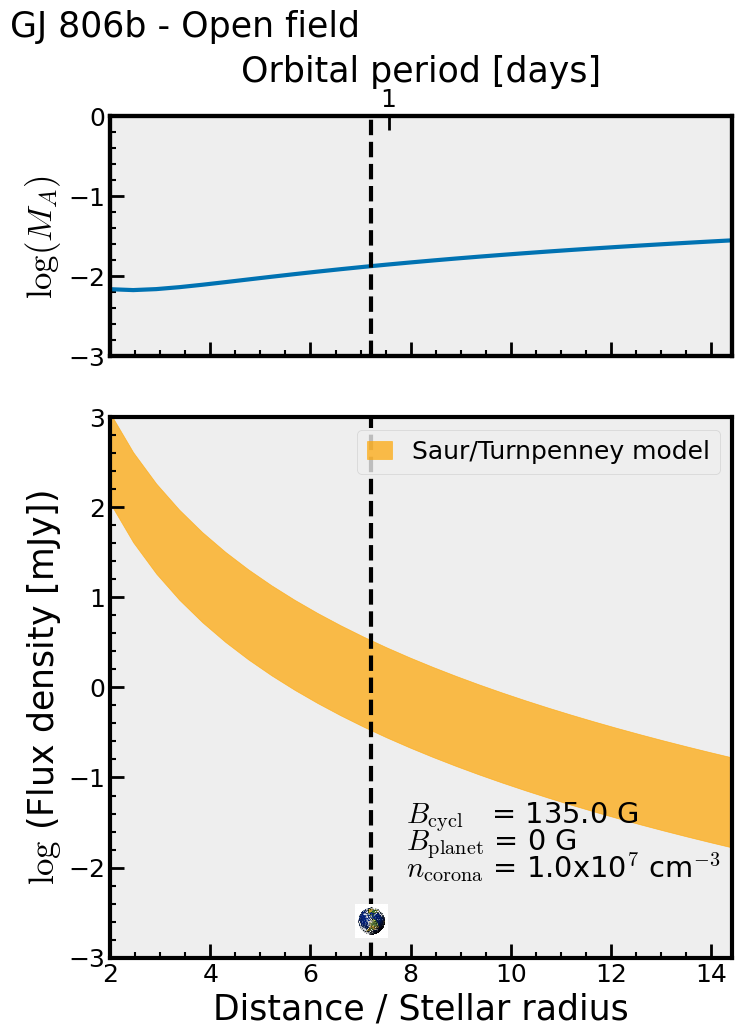

In [15]:
            ###########################################################################
            ####                  PLOTTING                                         ####
            ###########################################################################
            
            ### Plot received flux density as a function of distance from the star
            ###
            #matplotlib.rc_file_defaults()
            #plt.style.use(['bmh', '/home/torres/Dropbox/python/styles/paper.mplstyle'])

            lw = 3

            # Kepler's third law, with d_orb_mark in units of R_star, 
            # so that period_mark is in days.
            #
            period_mark = np.array([1, 3, 5, 10, 15, 20, 40, 80, 100])
            #period_mark = np.array([1, 10, 20, 40, 80, 100, 120, 140, 160,])
            d_orb_mark = (period_mark/yr)**(2/3) * M_star_msun**(1/3) * (au/R_star)

            # Plot only Flux density vs. orbital distance, or also log(M_A) vs. d_orb 
            multiple = 1
            if multiple:
                plt.figure(figsize=(8,11))
                ax1 = plt.subplot2grid((3,1),(0,0),rowspan=1,colspan=1)
                ax2 = plt.subplot2grid((3,1),(1,0),rowspan=2,colspan=1)
            else:
                plt.figure(figsize=(8,7.5))
                ax2 = plt.subplot2grid((1,1),(0,0),rowspan=1,colspan=1)


            x   = d_orb/R_star # (distance array, in units of R_star)

            y_min = np.log10(Flux_r_S_min) # minimum flux (array), Saur/Turnpenney model
            y_max = np.log10(Flux_r_S_max) # maximum flux (array)
            y_min_ZL = np.log10(Flux_r_S_ZL_min) # minimum flux (array), Zarka/Lanza model
            y_max_ZL = np.log10(Flux_r_S_ZL_max) # maximum flux (array)

            #
            #ax1.plot(x, np.log10(M_A), lw=lw)
            ax1.plot(x, np.log10(M_A), lw=lw)
            #ax2.plot(x, y_min, lw=lw, color='orange', lw=lw, label="Saur/Turnpenney model")
            #ax2.plot(x, y_max, lw=lw, color='orange')
            
            # Fill with color for ZL and ST models
            #
            #ax2.fill_between(x, y_min_ZL, y_max_ZL, color="blue", alpha=0.7, label="Zarka/Lanza model")
            ax2.fill_between(x, y_min, y_max,color="orange", alpha=0.7, label="Saur/Turnpenney model")


            #ax2.plot(dvec/R_star,np.log10(Flux_r_S), lw=lw, label="Saur/Turnpenney model")
            #ax2.plot(dvec/R_star,np.log10(Flux_r_S_ZL), lw=lw,label = "Zarka/Lanza model")
            #
            #ax2.fill_between([np.amin(dvec)/R_star,np.amax(dvec)/R_star], \
            #                 [np.log10(Poynt_min),np.log10(Poynt_min)], \
            #                 [np.log10(Poynt_max),np.log10(Poynt_max)],color="orange",alpha=0.4)

            ax11 = ax1.twiny()
            ax11.set_xticks(d_orb_mark)
            ax11.set_xticklabels(period_mark)
            ax11.tick_params(top=False,which='minor')
            ax1.tick_params(top=False,which='both')
            ax1.set_xticklabels([])
            #ax2.tick_params(labeltop=False, labelright=True)


            xmin = np.amin(d_orb)/R_star
            xmax = np.amax(d_orb)/R_star
            
            # Axis limits
            ax11.set_xlim([xmin, xmax])
            ax1.set_xlim([xmin, xmax])
            ax2.set_xlim([xmin, xmax])

            #ax11.set_xlim(5,50)
            #ax1.set_xlim(5,50)
            #ax2.set_xlim(5,50)

            #ax1.set_xscale('log')
            #ax2.set_xscale('log')
            #VALORES ORIGINALES
            ax1.set_ylim([-3,0])
            ax2.set_ylim([-3,3])
            #VALORES TEST
            #ax1.set_ylim([-50,20])
            #ax2.set_ylim([-50,80])

            ax1.axvline(x=r_orb/R_star, ls='--', color='k', lw=3)
            ax2.axvline(x=r_orb/R_star, ls='--', color='k', lw=3)

            # draw a little Earth at the planet position for visualization purposes
            paths = ['./pics/earth.jpg']
            x = [r_orb/R_star]
            y = [-2.6]
            for x0, y0, path in zip(x, y, paths):
                ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
                ax2.add_artist(ab)
    
            # If second planet 
            #
            # P_rot_2 = 23.0 # change it as appropriate
            # ax1.axvline(x=P_rot_2, ls='--', color='k', lw=3)
            # ax2.axvline(x=P_rot_2, ls='--', color='k', lw=3)
            
            #
            ax11.set_xlabel("Orbital period [days]")
            ax2.set_xlabel(r"Distance / Stellar radius")
            ax1.set_ylabel(r"${\rm log} (M_A)$")
            ax2.set_ylabel(r"${\rm log}$ (Flux density [mJy])")

            # draw 3*rms upper limit
            #ax2.axhline(y=np.log10(3*rms), ls='--', color='grey', lw=2)

            ax1.plot([xmin, xmax],[22,22],'k--') # This line needs to be modified to take into account different
            ax2.legend(loc=1)

            #ax2.text(x=60,y=1.8,s=r"$B_\ast = \,{\rm G}$")
            #ax2.text(x=60,y=1.4,s=r"$B_{\rm pl} = 1 \,{\rm G}$")
            #
            #ax2.text(x=12,y=-1.2,s=r"$B_{\rm cycl}$   = " + str(B0) + " G ",fontsize='small')
            #ax2.text(x=12,y=-1.6,s=r"$B_{\rm planet}$ = " + str(Bp0) + " G ", fontsize='small')
            #ax2.text(x=12,y=-2.0,s=r"$n_{\rm corona}$ = " + str(n_sw_base/1e7) + "x10$^7$ cm$^{-3}$ ", fontsize='small')
            #ax2.text(x=3,y=0.1+np.log10(3*rms),s=r"Requested 3$\sigma$", fontsize='x-small')
            xpos = d_orb_max/2 + 0.7
            ypos = -1.5
            d_ypos = 0.3
            ax2.text(x=xpos,y=ypos,s=r"$B_{\rm cycl}$   = " + str(B0) + " G ",fontsize='small')
            ax2.text(x=xpos,y=ypos-d_ypos,s=r"$B_{\rm planet}$ = " + str(Bp0) + " G ", fontsize='small')
            ax2.text(x=xpos,y=ypos-2*d_ypos, s=r"$n_{\rm corona}$ = " + str(n_sw_base/1e7) + "x10$^7$ cm$^{-3}$ ", fontsize='small')
        
            common_string = str(B0)+"G"+"-Bplanet"+str(Bp0)+"G"
            if open_field:
                ax1.text(x=0, y=1, s= Exoplanet + " - Open field")
                outfile = Exoplanet + "-Open-Bstar"+ common_string
            else:
                ax1.text(x=0, y=1, s= Exoplanet + " - Closed field")
                outfile = Exoplanet + "-Closed-Bstar"+ common_string

            plt.tight_layout()
            

            # Variable to send output to files (output=1), or show them in the notebook (output = 0) 
            output = 0
            
            if output:
                common_string = str(B0)+"G"+"-Bplanet"+str(Bp0)+"G"
                if open_field:
                    ax1.text(x=0, y=1, s= Exoplanet + " - Open field")
                    out = Exoplanet + "-Open-Bstar"+ common_string
                else:
                    ax1.text(x=0, y=1, s= Exoplanet + " - Closed field")
                    out = Exoplanet + "-Closed-Bstar"+ common_string
                
                outfilePDF = os.path.join(outdir, outfile+".pdf")
                plt.savefig(outfilePDF)
                plt.close()
            else:
                plt.show()
            
            
            #Print out relevant input and output parameters, including the expected flux received at Earth 
            # from the SPI at the position of the planet
            # To this end, first find out the position of the planet in the distance array
            d_diff = np.abs((d_orb-r_orb)/R_star)
            loc_pl = np.where(d_diff == d_diff.min())

            outfileTXT = os.path.join(outdir, outfile+'.txt')
            with open(outfileTXT, 'w') as f:
                f.write('# INPUT PARAMETERS:  ########\n') 
                f.write('B_star = {0:.0f} G; B_planet = {1:.0f} G\n'.format(B0, Bp0))
                f.write('# T_corona = {0:.0e} K\n'.format(T_corona))
                f.write('Stellar wind particle density at the base = {0:.0e} cm-3\n\n'.format(n_sw_base))
                f.write('# OUTPUT PARAMETERS: ########\n')
                f.write('ECMI freq (fundamental) = {0:.0f} MHz\n'.format(gyrofreq/1e6))
                f.write('Flux_ST: ({0}, {1}) mJy\n'.format(Flux_r_S_min[loc_pl], Flux_r_S_max[loc_pl]))
                f.write('Flux_ZL: ({0}, {1}) mJy\n'.format(Flux_r_S_ZL_min[loc_pl], Flux_r_S_ZL_max[loc_pl]))
            

In [16]:
# Print out the expected flux received at Earth from the SPI at the position of the planet

# First, find out the position of the planet in the distance array
d_diff = np.abs((d_orb-r_orb)/R_star)
location_pl = np.where(d_diff == d_diff.min())

#print('S_poynt: {0} erg/s\n'.format(S_poynt))
#print('Flux_ST: {0} mJy\n'.format(Flux_r_S_max))    
#print('Flux_ZL: {0} mJy\n'.format(Flux_r_S_ZL_max))    

# Print out minimum and maximum values of flux density at the planet location
print("B_star =", B0, " G; " "B_planet = ", Bp0, " G ")
print("\nPrint out Poynting Flux at the planet location")
print("Saur/Turnpenney (erg/s): ", S_poynt[location_pl])
print("\nPrint out Poynting Flux at the first cell")
print("Saur/Turnpenney (erg/s): ", S_poynt[0])

print("\nPrint out minimum and maximum values of flux density at the planet location")
print("Saur/Turnpenney (mJy): ", Flux_r_S_min[location_pl], Flux_r_S_max[location_pl])
#print("Zarka/Lanza: (mJy)", Flux_r_S_ZL_min[location_pl], Flux_r_S_ZL_max[location_pl])
print("\nPrint out minimum and maximum values of flux density at the first cell")
print("Saur/Turnpenney (mJy): ", Flux_r_S_min[0], Flux_r_S_max[0])
#print("Zarka/Lanza: (mJy)", Flux_r_S_ZL_min[0], Flux_r_S_ZL_max[0])

B_star = 135.0  G; B_planet =  0  G 

Print out Poynting Flux at the planet location
Saur/Turnpenney (erg/s):  [3.03662741e+23]

Print out Poynting Flux at the first cell
Saur/Turnpenney (erg/s):  9.227080597583016e+25

Print out minimum and maximum values of flux density at the planet location
Saur/Turnpenney (mJy):  [0.36629131] [3.66291313]

Print out minimum and maximum values of flux density at the first cell
Saur/Turnpenney (mJy):  111.30109220287599 1113.0109220287598
